# Analysis for Deep Learning, deep change? 

This notebook analyses a dataset of Arxiv papers for our Deep learning paper. 

**Activities**

* Load the data
* Initial exploration
* Produce a couple of charts for the AI Index including:
   * Trends in papers within AI related domains
   * Relative importance of DL, focusing on categories of interest (computer vision and natural language vs learning and stats)
   
* Carry out mapping analysis



## 0. Preamble

In [1]:
%matplotlib inline

#Some imports
import matplotlib.patches as mpatches

#Imports
#Key imports are loaded from my profile (see standard_imports.py in src folder).

#Paths

#Paths
top = os.path.dirname(os.getcwd())

#External data (to download the GRID database)
ext_data = os.path.join(top,'data/external')

#Interim data (to place seed etc)
int_data = os.path.join(top,'data/interim')

#Figures
fig_path = os.path.join(top,'reports/figures')

#Models
mod_path = os.path.join(top,'models')


#Get date for saving files
today = datetime.datetime.today()

today_str = "_".join([str(x) for x in [today.day,today.month,today.year]])


## 1. Load data

We are going to work with data which have classified DL papers based on different strategies and compare results for robustness. Write a pipeiline that does this automatically


In [2]:
# Initial exploration before writing the pipeline

papers = pd.read_json(ext_data+'/CsDl_CorExCompoundsFull_MakGridMatched_withCountries.json',orient='records')

papers.shape

(116730, 19)

There are 116,730 papers. This is the total number of CS + Stats papers in Arxiv?

In [3]:
#Let's check the variables
papers.head()

,arxiv_cat,arxiv_id,categories,cex_isDL_1,cex_isDL_1.5,citations,cities,city,codes,countries,date,institutes,lat_lon_score,lda_isDL,matched,pid,publication_year,summary,title
0,cs.NE,704.0047,"[cs.NE, cs.AI]",False,False,8.0,[Ljubljana],NaN,[SI],[Slovenia],1.041466e+12,[university of ljubljana],"[[46.049268, 14.505099, 1.0]]",False,True,http://arxiv.org/abs/0704.0047v1,2007,"[intelligent, acoustic, emission, locator, des...",intelligent location of simultaneously active ...
1,cs.NE,704.0050,"[cs.NE, cs.AI]",False,False,0.0,[Ljubljana],NaN,[SI],[Slovenia],1.175386e+12,[university of ljubljana],"[[46.049268, 14.505099, 1.0]]",False,True,http://arxiv.org/abs/0704.0050v1,2007,"[part, describes, intelligent, acoustic, emiss...",intelligent location of simultaneously active ...
2,cs.DS,704.0062,[cs.DS],False,False,NaN,[],NaN,[],[],NaN,None,[],False,False,http://arxiv.org/abs/0704.0062v1,2007,"[paper, introduce, line, viterbi, algorithm, d...",on line viterbi algorithm and its relationship...
3,cs.CE,704.0090,"[cs.CE, cond-mat.stat-mech, cs.MS, cs.NA, phys...",False,False,NaN,[],NaN,[],[],NaN,None,[],False,False,http://arxiv.org/abs/0704.0090v1,2007,"[real, option, project, schedule, rops, ha, th...",real options for project schedules rops
4,cs.CC,704.0108,[cs.CC],False,False,0.0,[],NaN,[],[],1.175386e+12,[],[],False,True,http://arxiv.org/abs/0704.0108v1,2007,"[description, polynomial, time, reduction, sat...",reducing sat to 2 sat


In [4]:
#Tidy the variable names
papers.columns = ['category','id','categories','is_dl_cex1','is_dl_cex15','citations',
                  'cities','city','codes','countries',
                  'date','organisations','lat_lon','is_dl_lda','mak_match','abstract','year',
                  'summary','title']

### Plot paper trends

I will write a class to do this. 

The class takes a json file and a Deep Learning flags.

We use its methods to:

* Plot trends in DL compared to the total (also with a filter that focuses on highly cited papers in the period
* Plot trends in DL by subcategory compared to the total (also with a highly cited filter)
* Plot totals in DL-heavy topics
* Extract top keywords by category and year.

In [5]:
class dlPaperAnalysis():
    '''
    The class takes a json file and a Deep Learning flags.
    -We use its methods to:
        -Plot trends in DL compared to the total 
        (also with a filter that focuses on highly cited papers in the period
        -Plot trends in DL by subcategory compared to the total (also with a highly cited filter)
        -Plot totals in DL-heavy topics
        -Extract top keywords by category and year.
    
    '''
    
    def __init__(self,file,variable):
        '''
        Initialise the class with a file and a variable to flag dl papers. This 
        can be the different files we have previously used in our analysis
        
        '''
        
        self.papers = file
        self.dl_flag = variable
        self.flag_short = variable.split("_")[-1]
         
        
    def generate_total_report(self):
        '''
        This generates a df with the total number of DL papers 
        
        '''
        
        #Load papers
        papers = self.papers
        
        #Load the flag
        flag = self.dl_flag
        
        #Generate paper counts
        dl_counts = papers[flag].value_counts()
        
        #Concatenate with shares
        dl_counts_shares = pd.concat([dl_counts,100*dl_counts/dl_counts.sum()],axis=1)
        
        dl_counts_shares.columns = [self.flag_short+'_count',self.flag_short+'_pc']
        
        self.dl_totals= dl_counts_shares
        
    def generate_year_reports(self):
        '''
        This generates a df with DL papers by year, and their share of the total
        
        '''
        #Load papers
        papers = self.papers
        
        #Load the flag
        flag = self.dl_flag     
        
        
        #Cross tabs
        timelines = make_crosstab(papers,'year',flag)
        
        
        #Store
        self.year_count = timelines[0]
        self.year_share = timelines[1]
        
    def generate_cat_reports(self,num=10):
        '''
        
        This generates a df with DL papers by cat and their share of the total
        
        '''
        
        #Load papers
        papers = self.papers
        flag = self.dl_flag
        
        #Generate and store a ranking of categories based on importance
        self.top_cats = papers.category.value_counts().index[:num]
        
        
        #Cross tab by category
        categories = make_crosstab(papers,'category',flag)
        
        #Store
        self.cat_count = categories[0]
        self.cat_share = categories[1]
        
        #Also store the top DL categories
        self.top_dl_cats = categories[0].sort_values(categories[0].columns[1],ascending=False)[:num]
        
        
    
    def generate_cat_years_reports(self):
        '''
        This generates, for each category, dl year counts and value counts
        
        
        '''
        
        #Initialise everything
        papers = self.papers
        flag = self.dl_flag
        
        #Dictionaries that stores counts and shares of papers in a category
        cats_store_count = {}
        cats_store_share = {}
        
        for x in set(papers.category):
            
            #Papers in category
            papers_selected = papers.loc[papers.category==x,:]
            
            timelines = make_crosstab(papers_selected,'year',flag)
            
            #Store
            cats_store_count[x] = timelines[0]
            cats_store_share[x] = timelines[1]
        
        #Store
        self.category_dl_counts = cats_store_count
        self.category_dl_shares = cats_store_share
            
            
    def plot_categories(self,ax=None,share=False,num=10):
        '''
        Plot the levels of dl activity by category (not considering time)
        
        #Num determines the number of categories to plot
        
        '''
        
        #This is to sort the data by the top categories
        focus_categories = self.cat_count.sum(axis=1).sort_values(ascending=False).index[:num]
        
        if share==False:
            data = self.cat_count.iloc[:,[1,0]]
            data_sorted = data.loc[focus_categories,:]
            
            data_sorted.plot.bar(ax=ax,
                                 title="Number of papers by Arxiv category and DL \n according to {x} definition".format(x=self.flag_short),
                                colors=['darkorange','darkblue'])
            
        else:
            
            data = self.cat_share.iloc[:,[1,0]]
            
            data_sorted = data.loc[focus_categories,:]
            
            data_sorted.plot.bar(ax=ax,stacked=True,
                                title="Share of DL papers in Arxiv category \n according to {x} definition".format(x=self.flag_short),
                                colors=['darkorange','darkblue'])
        
        
        
    
    
    
    def plot_years(self,ax=None,category='all',stacked=False):
        '''
        Returns a linechart
        
        '''
        
        #If we want to plot all, we use year count. Otherwise we look for the right count below.
        
        #If we want to plot all do it this way.
        if category=='all':
            
            #If we want a linechart
            if stacked==False:
                data= self.year_count
                
                data.plot(title='Levels of Arxiv and DL activity \n according to {x} definition'.format(x=self.flag_short),
                                ax=ax,color=['darkblue','darkorange'])
                
            #If we want a stacked plot
            else:
                data = self.year_share.iloc[:,[1,0]]
                data.plot.bar(title='Shares DL activity \n according to {x} definition'.format(
                    x=self.flag_short),ax=ax,stacked=True,color=['darkorange','darkblue'])
            
        #This starts to get a bit more complicated
        else:
            
            #Again, it depends on whether we want to stack or not
            
            if stacked==False:   
                #Extract and subset papers                
                data= self.category_dl_counts[category]
            
                data.plot(
                    title='Levels of Arxiv and DL activity in category {cat} \n according to {x} definition'.format(
                        x=self.flag_short,cat=category),ax=ax,color=['darkblue','darkorange'])
            
            
            else:
                #Extract share data
                data = self.category_dl_shares[category].iloc[:,[1,0]]
                
                data.plot.bar(title='Shares DL activity in category {cat} \n according to {x} definition'.format(
                    x=self.flag_short,cat=category),ax=ax,stacked=True,color=['darkorange','darkblue'])
                
            
        
        

In [6]:
def make_crosstab(df,category,flag,ct=False):
    '''
    Takes a df and creates a timeline (year count)
    
    '''
    
    dl = pd.crosstab(df[category],df[flag])
    dl_norm = pd.crosstab(df[category],df[flag],normalize=0)
        
    #Add names with the flag identifier
    var_names = ['not_dl_'+flag.split("_")[-1],'dl_'+flag.split("_")[-1]]
        
    #Rename the dfs (we add len in case there are categories with no DL papers)
    dl.columns=var_names[:len(dl.columns)]
    dl_norm.columns = var_names[:len(dl.columns)]

    return([dl,dl_norm])
    

In [7]:
def generate_all_reports(df,flag):
    '''
    Takes a flag for DL papers and runs all the methods in the class above

    '''

    init_class = dlPaperAnalysis(df,flag)

    init_class.generate_total_report()

    init_class.dl_totals

    init_class.generate_year_reports()

    init_class.generate_cat_reports()

    init_class.generate_cat_years_reports()

    return(init_class)

In [8]:
dl_ces1_class = generate_all_reports(papers,flag='is_dl_cex1')

In [9]:
def prettify_all_trends(read_class,title_addition=None):
    '''
    This function prettifies the trends charts for all papers.
    
    '''
    
    fig,ax = plt.subplots(figsize=(10,5),nrows=2)

    read_class.plot_years(ax=ax[0],category='all')
    read_class.plot_years(ax=ax[1],category='all',stacked=True)


    #Prettify
    ax[0].get_xaxis().set_visible(False)
    ax[1].tick_params(axis='x',rotation=60)

    ax[1].set_xlabel('')
    ax[1].get_legend().set_visible(False)

    ax[0].legend(labels=['Non Deep Learning papers','Deep Learning papers'],title='Paper classification')

    #Change titles
    
    if title_addition==None:
        ax[0].set_title(
            'Levels of activity in Arxiv by classification outcome \n (Number of papers and shares of total)',
        size=16)
    
    else:
        ax[0].set_title(
            'Levels of activity in Arxiv by classification outcome \n (Number of papers and shares of total) - {x}'.format(
            x=title_addition))
    
    ax[1].set_title('')


    plt.subplots_adjust(hspace=0)
    
    

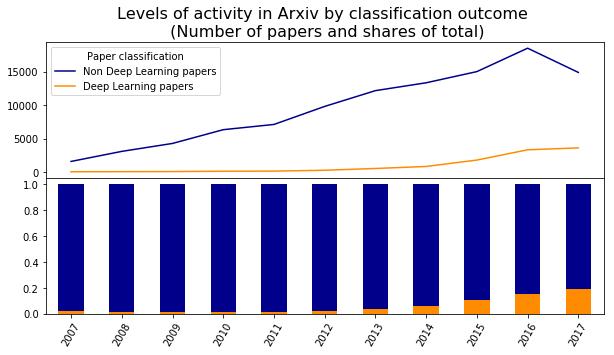

In [10]:
prettify_all_trends(dl_ces1_class)

plt.savefig(fig_path+'/{date}_dl_trends.pdf'.format(date=today_str))


### Plot papers by Arxiv category

/usr/local/lib/python3.5/site-packages/pandas/plotting/_core.py:188: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


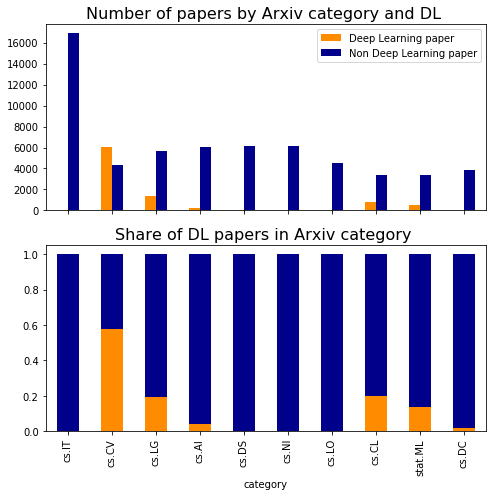

In [11]:
fig,ax = plt.subplots(figsize=(7,7),nrows=2,sharex=True)

dl_ces1_class.plot_categories(ax=ax[0])
dl_ces1_class.plot_categories(ax=ax[1],share=True)


#Change size of titles for readability and remove reference to DL definition
ax[0].set_title(ax[0].get_title().split('\n')[0],size=16)
ax[1].set_title(ax[1].get_title().split('\n')[0],size=16)
ax[1].get_legend().set_visible(False)

ax[0].legend(labels=['Deep Learning paper','Non Deep Learning paper'])

plt.tight_layout()

plt.savefig(fig_path+'/{date}_paper_categories.pdf'.format(date=today_str))

### Plot paper trends by subcategory

In [12]:
#Domains with some DL activity
dl_areas = dl_ces1_class.cat_count.sort_values('dl_cex1',ascending=False).index[:10]

In [13]:
def prettify_subcat_trends(read_class,cats,title_addition=None):
    '''
    Prettifies the year plots based on categories
    Title addition adds something to the title to clarify results
    areas selects the areas to visualsie
    
    '''
    
    fig,ax = plt.subplots(nrows=10,ncols=2,figsize=(10,12),sharex='col')

    for num,x in enumerate(cats):
        #Line chart
        read_class.plot_years(category=x,ax=ax[num][0])

        #Stack
        read_class.plot_years(category=x,ax=ax[num][1],stacked=True)


        #Remove legends and titles
        ax[num][0].set_title(x+': Total papers')
        ax[num][1].set_title(x+': Share of total')

        ax[num][1].hlines(y=0.5,xmin=-0.5,xmax=11,color='white')

        #[ax[num][val].set_title('') for val in [0,1]]
        [ax[num][val].get_legend().set_visible(False) for val in [0,1]]
    
    
    if title_addition==None:
        fig.suptitle('Levels and shares of Arxiv activity by category',y=1.02)
    else:
        fig.suptitle('Levels and shares of Arxiv activity by category - {x}'.format(x=title_addition))
    
    plt.tight_layout()

    
    

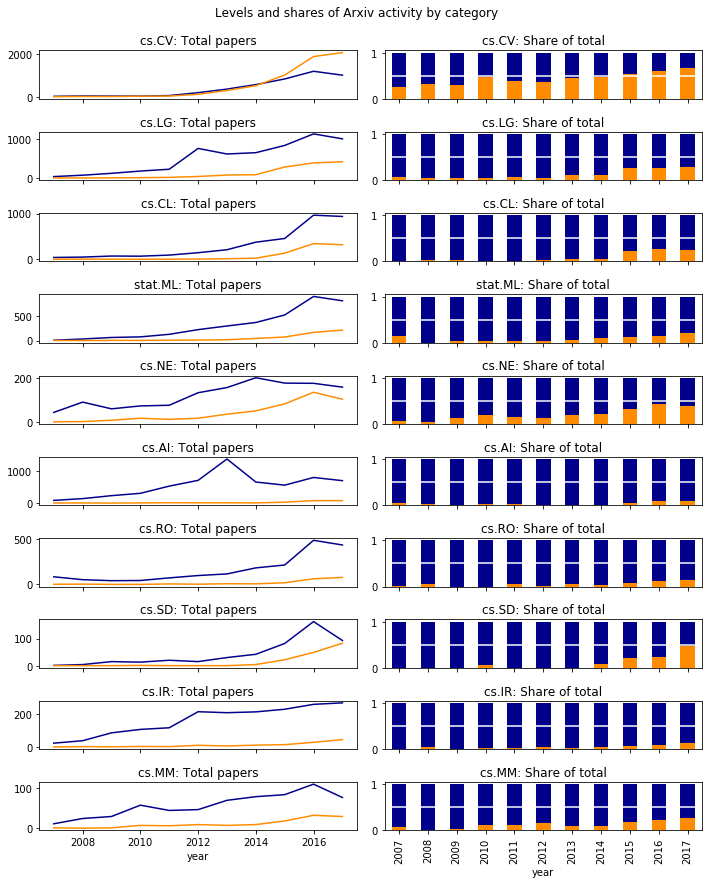

In [14]:
prettify_subcat_trends(dl_ces1_class,cats=dl_areas)

### Are these things robust to more stringent selection?

We will group by year and only focus on the top 25 papers each year in terms of citations. Is the advent of DL still visible?



In [15]:
#Top percentile of highly cited papers
year_quartile_citations = papers.groupby('year')['citations'].quantile(0.99)

#Which ones are they?
papers['highly_cited'] = [x>year_quartile_citations[y] for x,y in zip(papers.citations,papers.year)]

#Subset the data
papers_highly_cited = papers.loc[papers.highly_cited==True,:]

#Process with the previous definition
dl_ces1_cited_class = generate_all_reports(papers_highly_cited,flag='is_dl_cex1')

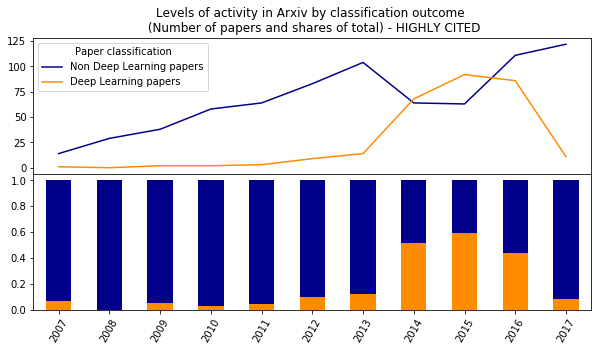

In [16]:
#Plot pretty

prettify_all_trends(dl_ces1_cited_class,title_addition='HIGHLY CITED')


/usr/local/lib/python3.5/site-packages/pandas/plotting/_core.py:188: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


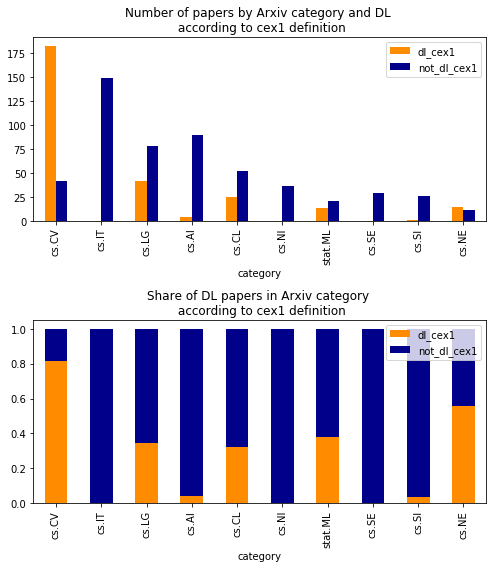

In [17]:
#Top cited by area

fig,ax = plt.subplots(figsize=(7,8),nrows=2)

dl_ces1_cited_class.plot_categories(ax=ax[0])
dl_ces1_cited_class.plot_categories(ax=ax[1],share=True)

plt.tight_layout()

### Plot activity by category separating DL intensive and non DL intensive domains

In [18]:
#Domains with some DL activity
dl_areas = dl_ces1_class.cat_count.sort_values('dl_cex1',ascending=False).index[:10]

/usr/local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:521: UserWarning: You have mixed positional and keyword arguments, some input will be discarded.
  warnings.warn("You have mixed positional and keyword "


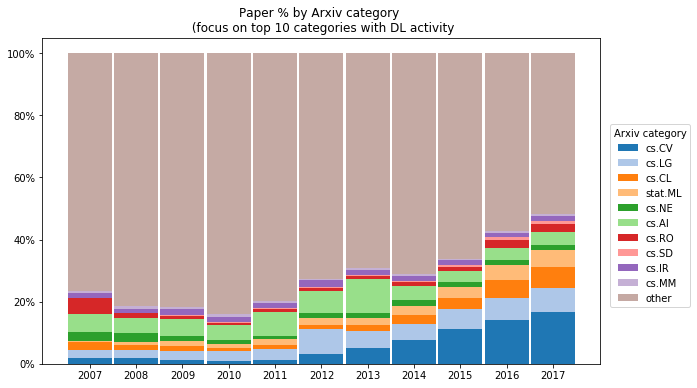

In [19]:
# Plot activity by category - 

papers['categories_big'] = [x if x in dl_areas else 'other' for x in papers.category]


cats_year = pd.crosstab(papers.year,papers.categories_big,normalize=0).loc[:,list(dl_areas)+['other']]

#Old school barchart

colors = plt.cm.get_cmap('tab20').colors[:len(cats_year.columns)]

color_lookup = {x:y for x,y in zip(cats_year.columns,colors)}

fig,ax = plt.subplots(figsize=(10,6))

bottom = np.array([0]*len(cats_year))

for x in cats_year.columns:
    ax.bar(np.arange(len(cats_year)),
           height=cats_year[x],
           bottom=bottom,
           color=color_lookup[x],width=0.95,
           alpha=1 if x !='other' else 0.5
          )
    
    
    bottom = bottom+cats_year[x]

ax.set_xticks(np.arange(len(cats_year.index)))
ax.set_xticklabels(cats_year.index)
ax.set_title('Paper % by Arxiv category \n (focus on top 10 categories with DL activity')

la = ax.get_yticklabels()

ax.set_yticklabels([str(int(100*x))+'%' for x in np.arange(0,1.1,0.2)])


patches = [mpatches.Patch(color=c,label=l) for l,c in color_lookup.items()]

ax.legend(patches,
          labels=cats_year.columns,bbox_to_anchor=(1.17,0.75),title='Arxiv category')

### Geographical analysis

We will differentiate popular CS areas between 'high', 'medium' and 'low' level of adoption of AI, and compare their geographical concentration. Some of the ways we will look at this:

* Country trends grouped by those areas
* Volatility in LQs
* Churn



In [20]:
#Deal with chained assignment errors
pd.options.mode.chained_assignment= None

#Function to flatten dataframe
def flat_dataframe(observation):
    '''
    Takes an observation in a df where one of the variables is nested and returns a flat one
    (each row is repeated for the variable we want to flatten)
    This could be made more general and faster based on Joel's code.
    
    '''
    #If the paper has several author countries/institutions we create a single row for each
    #with all the geo data
    
    if len(observation['countries'])>1:
        container = []
        for num,x in enumerate(observation['countries']):
            new_df = observation.copy()
            new_df['country'] = observation['countries'][num]
            new_df['city'] = observation['cities'][num]
            new_df['organisation'] = observation['organisations'][num]
            new_df['lat_lons'] = observation['lat_lon'][num]
            new_df['iso_code'] = observation['codes'][num]
            
            container.append(new_df)
            
        out_df = pd.concat(container,axis=1).T.reset_index(drop=True)
        return(out_df)
    
    else:
        new_df = pd.DataFrame(observation.copy()).T
        return(new_df)
    
    
#Functions
def create_lq_df(df,year=None):
    '''
    Takes a df with cells = activity in col in row and returns a df with cells = lq
    
    '''
    
    area_activity = df.sum(axis=0)
    area_shares = area_activity/area_activity.sum()
    
    lqs = df.apply(lambda x: (x/x.sum())/area_shares, axis=1)
    
    if year!=None:
        lqs['period'] = year
    
    return(lqs)

             
def calculate_specialisation(df,unit_analysis):
    '''
    This function calculates the specialisation for an area count LQ.
    It groups the data by period, extracts LQs and labels with the period

    '''
    #Group the df by year
    grouped = df.groupby('period')
    
    #Extract the LQ. We take each group in the data and calculate its LQ, we then concatenate
    spec = pd.concat([create_lq_df(grouped.get_group(y).drop('period',axis=1).set_index(unit_analysis),
                                                 year=y) for y in grouped.groups.keys()])
    
    
    #Out
    return(spec)

def generate_area_stats(df,category,unit_analysis,period='yearly'):
    '''
    This function groups the df by a category (we assume adoption group) and a unit of analysis
    which could be a country, a city or an institution and returns counts and LQs and periods.
    if we use period, it does this by year. If not, we need to supply a year it will use 
    to split the data into a before and after
    
    It returns a count of papers per year and period in different categories, and the LQ.
    
    '''
    
    #Create a variable to group by for the timeseries
    if period!='all':
        df['period'] = ['first_period' if x<=int(period) else 'second_period' for x in df.year]
        
    else:
        df['period'] = df['year']
        
    #Group
    period_unit_counts = df.groupby(['period',category,unit_analysis])['id'].count().reset_index(drop=False)
    
    #Widen
    period_unit_counts_wide = pd.pivot_table(period_unit_counts,index=['period',unit_analysis],
                                            columns=category,values='id').reset_index(drop=False).fillna(0)
    
    return(period_unit_counts_wide)
    

In [21]:
%%time

#Current file has multiple locations/ institutions etc for each file. 
#We need to flatten the papers df into one where every observation is a participating institution


papers_flat = pd.concat([flat_dataframe(papers.loc[num,:]) for num in np.arange(len(papers))],axis=0).reset_index(drop=True)

CPU times: user 8min 16s, sys: 6.36 s, total: 8min 22s
Wall time: 8min 42s


In [22]:
class dlPaperGeoAnalysis():
    '''
    This class processes and performs geographical analyses of DL classes based on 
    a tidy df, and a DL paper definition
    of AI adoption
    
    Some of its methods:
    
    -A .create_adoption_groups method to allocate papers into categories (high / medium / low) with a threshold
    parameter
    -A  .geo_trends method that groups papers by year / country / category, year / city / category and extracts
    counts and LQs
    
    -A .get_churn method that groups papers by category and extracts churn (eg number if new entrants and leavers)
    in the top (hyperparameter) organisations.
    
    -A .get_divergence method that for each category and year compares activity in DL and non DL papers
    
    -Plot methods to display all this
    '''
    
    def __init__(self,input_file,input_file_flat,flag_variable):
        '''
        Initialises the class with an input flag and a class variable
        NB this also takes the flat version of the data which we use in all the geo analysis
        '''
        
        self.papers = input_file
        self.papers_flat = input_file_flat
        
        self.flag = flag_variable
        self.flag_short = flag_variable.split("_")[-1]
        

    def create_adoption_groups(self, thresholds=[0.2,0.05]):
        '''
        Classifies categories (and papers) into 'high', 'medium' and 'low' adoption groups based on the
        relative importance of DL in them in the most recent period. 
        Thresholds is a list with two elements separating high from medium and medium from low
        
        #How do we select the threshold values? We could carry out the rest of the
        analysis ignoring the 'medium' (boundary) group, which isn't too big anyway. To be decided.
        
        '''
        #Load papers
        papers = self.papers
        dl_var = self.flag
        
        #Create counts in the most recent year by category
        year_cat_counts = papers.loc[papers.year>2015,:].groupby(
            ['category',dl_var])['id'].count().reset_index(drop=False)
        
        #Pivot it to generate shares
        recent_cat_dl_wide = pd.pivot_table(year_cat_counts,index='category',columns='is_dl_cex1',values='id')
        
        #Rename
        recent_cat_dl_wide.columns = ['not_dl','is_dl']
        
        #Create share
        recent_cat_dl_wide['dl_share'] = recent_cat_dl_wide['is_dl']/recent_cat_dl_wide.sum(axis=1)

        #Allocate to categories
        recent_cat_dl_wide['adoption_group'] = ['high' if x>thresholds[0] 
                                                else 'medium' if x > thresholds[1] else 'low' for
                                               x in recent_cat_dl_wide['dl_share']]
        
        #Create a dict looking up categories vs adoption groups
        cat_ad_group_lookup = {x:y for x,y in zip(recent_cat_dl_wide.index,recent_cat_dl_wide.adoption_group)}
        
        self.cat_to_adopt_lookup = cat_ad_group_lookup
        
        #Group categories by adoption group
        adoption_groups = recent_cat_dl_wide.reset_index(drop=False).groupby(
            'adoption_group')['category'].apply(lambda x: list(x))
        
        #Store as a dict with keys = adoption groups and values = categories
        self.adopt_to_cat_lookup = {x:y for x,y in zip(adoption_groups.index,adoption_groups)}
        
        #Allocate papers to groups
        papers['adoption_group'] = [cat_ad_group_lookup[x] for x in papers.category]
        
        
        #Create and store a paper id - adoption group lookup we use to relabel the flat papers later
        self.paper_id_group = {x:y for x,y in zip(papers['id'],papers['adoption_group'])}
        
        
        #Update the papers df
        self.papers = papers
        
        return(self)
        
        
    def focus_on_highly_cited(self,pc=x):
        '''
        If we select this, all the analysis will focus on highly cited papers selected based on
        a percentile for field and year.
        
        '''
        
        #Extract papers
        papers = self.papers
        papers_flat = self.papers_flat
        
        papers_highly_cited = get_most_cited(papers)
        
        #Store (and remember we are focusing on highly cited!)
        self.papers = papers_highly_cited
        
        #Get highly cited ids to subset the flat paper list
        high_ids = list(papers_highly_cited['id'])
        
        #Subset flat papers
        papers_highly_cited_flat = papers_flat.loc[[x in high_ids for x in papers_flat['id']],:]
        
        self.papers_flat = papers_highly_cited_flat
        
        return(self)
        
    def create_geo_trends_adoption(self,period='2012'):
        '''
        This method groups papers by adoption groups, countries and cities and returns counts
        
        '''
        
        #Load papers
        papers_flat = self.papers_flat
        
        papers_flat['adoption_group'] = [self.paper_id_group[x] for x in papers_flat['id']]
        
        #Create counts of papers by area
        country_counts,city_counts,org_counts = [generate_area_stats(
            papers_flat,category='adoption_group',unit_analysis=x,
                                         period=period) for x in ['country','city','organisation']]
        
        
        #Create shares of papers by area
        country_shares,city_shares,org_shares = [get_area_shares(x,y) for x,y in zip([country_counts,city_counts,org_counts],
                                            ['country','city','organisation'])]
        
        
        #Create LQs
        #This requires grouping each count lq by period, concatenate them
        
        country_lqs,city_lqs,org_lqs = [calculate_specialisation(x,y) for x,y in zip([country_counts,city_counts,org_counts],
                                            ['country','city','organisation'])]
        
        
        self.country_stats = [country_counts,country_shares,country_lqs]
        self.city_stats = [city_counts,city_shares,city_lqs]
        self.org_stats = [org_counts,org_shares,org_lqs] 
        
        return(self)
    
    
    

In [23]:
def get_area_shares(df,unit_analysis):
    '''
    This function extracts, for the stats counts in a unit of analysis, the 
    shares of activity of the unit for different adoption groups
    '''
    
    #Create a df with the name of the location and the period
    df_shares = df[[unit_analysis,'period']]
    
    #Extract the shares
    df_shares[['high_share','low_share','medium_share']] = 100*df.groupby(
        'period')[['high','low','medium']].apply(lambda x: x/x.sum())

    return(df_shares)


def get_most_cited(df,pc=0.75):
    '''
    This function takes a df and subsets it to focus on the most cited papers in a given category and year
    
    '''
    #Find the citation percentile for each year and category
    year_pc_citations = df.groupby(['year','category'])['citations'].quantile(pc)
    
    #Mask the papers to focus on highly cited ones
    df['highly_cited'] = [x>year_pc_citations.loc[(y,cat)] for x,y,cat in zip(df.citations,df.year,df.category)]
    
    #Return a subset of highly cited papers
    df_high = df.loc[[x == True for x in df['highly_cited']],:].reset_index(drop=True)

    return(df_high)
    
    
    

#### First analysis:

* Look at the evolution in totals and LQs for the first 10 countries by activity. 

Some observations: do this on a yearly basis in a line chart. Do we want to turn this into a method?
Yes, eventually.







In [24]:
changes_2012 = dlPaperGeoAnalysis(papers,papers_flat,'is_dl_cex1').create_adoption_groups().create_geo_trends_adoption()

In [25]:
country_shares = changes_2012.country_stats[1]

#Country stats
country_stats = changes_2012.country_stats[0]

#Find top countries
top_20_countries = list(country_stats.groupby('country').sum().sum(axis=1).sort_values(ascending=False).index[:20])

#Map activity in each area for the top 10 countries. How to visualise?
country_shares['country'] = [x if x in top_20_countries else 'Other' for x in country_shares['country']]

#Regroup
#Regroup
country_shares_selected = country_shares.groupby(
    ['country','period'])[['high_share','low_share','medium_share']].sum().reset_index(drop=False)

nice_legends = ['Low deep learning adoption Arxiv categories','High deep learning adoption Arxiv categories']

countries_ranked = top_20_countries+['Other']


In [26]:
def plot_place_shares(activity_df,unit,title,nice_titles,
                      y_position,y_title,
                      bar_ranking,break_y='2012'):
    '''
    This function takes an activity df and returns a plot comparing activity before and 
    after a break off period. 
    
    Some inputs:
    -unit= unit of observation (country, city, organisation)
    -title
    -nice legends
    -y position to adjust summary stats
    -bar ranking to rank the columns in the barchart
    
    '''
    
    fig,ax = plt.subplots(figsize=(12,7),nrows=2,sharex=True,sharey=True)

    #For each variable
    for num,category in enumerate(['low_share','high_share']):
        data = pd.pivot_table(
            activity_df[[unit,'period',category]],index='country',
            columns='period',values=category)
        
        #We want to obtain some statistics about the data
        data['change'] = (data['second_period']/data['first_period'])-1

        mean_change = np.round(np.mean(data['change']),2)
        variance = np.round(np.var(data['change']),2)
        
        #Identify big positive and negative changers
        big_changers_pos = [x for x,y in zip(data.index,data.change) if y>0.3]
        big_changers_neg = [x for x,y in zip(data.index,data.change) if y<-0.3]


        #Plot each column
        for num_c, place in enumerate(bar_ranking):
            ax[num].bar(x=num_c-0.125,height=data.loc[place,'first_period'],width=0.25,color='darkblue',
                   hatch='////' if place in big_changers_pos else '\\\\\\' if place in big_changers_neg else None)

            ax[num].bar(x=num_c+0.125,height=data.loc[place,'second_period'],width=0.25,color='darkorange',
                        hatch='////' if place in big_changers_pos else  '\\\\\\' if place in big_changers_neg else None)


        ax[num].annotate(s='{title} \n Change (mean)={m} \n Change (variance)={v}'.format(
            title=nice_titles[num],
            m=mean_change,
            v=variance),
                         xy=(10,y_position),ha='center',size=14,
                         bbox=dict(boxstyle='round',facecolor='white')
                        )

    #Prettify labels
    ax[0].legend(labels=['Before '+break_y,'After '+break_y],loc='upper right',fontsize=12)
    ax[1].legend(labels=['Before '+break_y,'After '+break_y],loc='upper right',fontsize=12)
    ax[1].set_xticks(np.arange(0,len(bar_ranking)))
    ax[1].set_xticklabels(bar_ranking,rotation=45,size=14,
                          ha='right'
                         )

    ax[0].set_ylabel('% of papers',size=14)
    ax[1].set_ylabel('% of papers',size=14)

    plt.tight_layout()

    fig.suptitle(title,size=18,y=y_title)

    
    

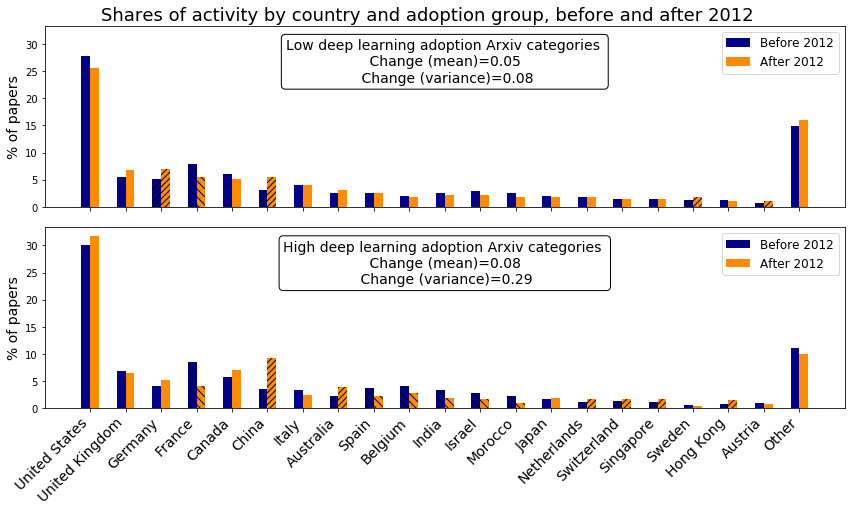

In [27]:
plot_place_shares(country_shares_selected,'country',
                   title='Shares of activity by country and adoption group, before and after 2012',
                   nice_titles=nice_legends,
                   y_position=23,y_title=1.01,
                   bar_ranking=countries_ranked)

plt.savefig(fig_path+'/{date}_country_comparison_all.pdf'.format(date=today_str),bbox_inches='tight')

In [28]:
changes_2012_high_cit = dlPaperGeoAnalysis(
    papers,papers_flat,'is_dl_cex1').create_adoption_groups().focus_on_highly_cited().create_geo_trends_adoption()

In [29]:
country_shares = changes_2012_high_cit.country_stats[1]

#Country stats
country_stats = changes_2012_high_cit.country_stats[0]

#Find top countries
top_20_countries = list(country_stats.groupby('country').sum().sum(axis=1).sort_values(ascending=False).index[:20])

#Map activity in each area for the top 10 countries. How to visualise?
country_shares['country'] = [x if x in top_20_countries else 'Other' for x in country_shares['country']]

#Regroup
#Regroup
country_shares_selected = country_shares.groupby(
    ['country','period'])[['high_share','low_share','medium_share']].sum().reset_index(drop=False)

nice_legends = ['Low deep Learning adoption Arxiv categories','High deep learning adoption Arxiv categories']

countries_ranked = top_20_countries+['Other']

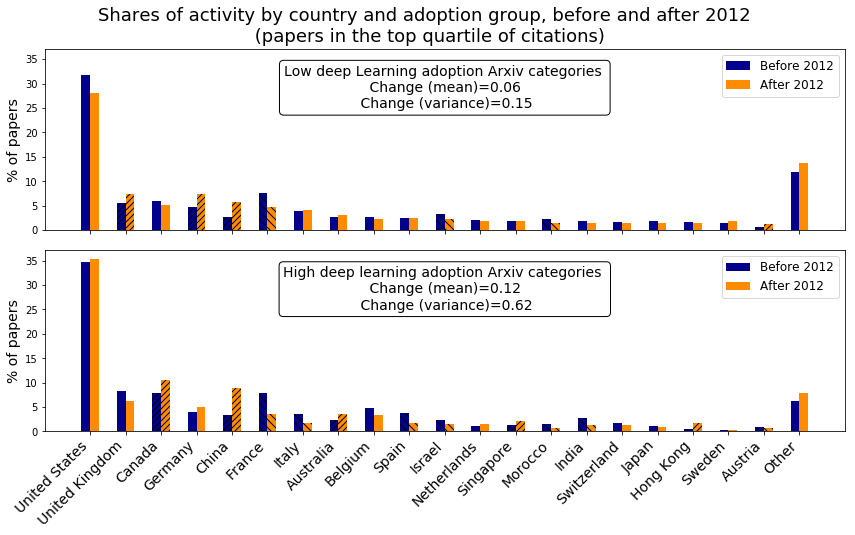

In [30]:
plot_place_shares(country_shares_selected,'country',
                   title='Shares of activity by country and adoption group, before and after 2012 \n (papers in the top quartile of citations)',
                   nice_titles=nice_legends,
                   y_position=25,y_title=1.055,
                   bar_ranking=countries_ranked)

plt.savefig(fig_path+'/{date}_country_comparison_highly_cited.pdf'.format(date=today_str),bbox_inches='tight')


#### Compare cities

What strategy do we use to do this?

* Changes in market shares



In [31]:
#To regress
from scipy.stats import linregress

In [32]:
changes_2012 = dlPaperGeoAnalysis(
    papers,papers_flat,'is_dl_cex1').create_adoption_groups().create_geo_trends_adoption(
    period='2012')

In [33]:
def plot_shares_comparison(changes_class,title,pc_to_consider=0.9):
    '''
    
    This function creates a plot comparing research activity in 2 periods, focusing on 'high' and 'medium'
    adoption groups
    
    '''
    
    #Find large organisations and analyse activity
    org_counts = changes_class.org_stats[0]
    org_shares = changes_class.org_stats[1]
    
    #Get groups
    top_orgs = org_counts.groupby(['organisation','period'])[['high','medium','low']].sum().sum(axis=1)
    
    #Select larger orgs
    focus_orgs = top_orgs[top_orgs>top_orgs.quantile(pc_to_consider)].index
    
    #Create wide set
    shares_low,shares_high,shares_medium = [pd.pivot_table(org_shares,
                                                          index='organisation',columns='period',
                                                          values=var) for var in ['low_share','high_share',
                                                                                 'medium_share']]
    
    
    fig,ax = plt.subplots(figsize=(7,7),nrows=2,sharex=True,sharey=True)

    color_lookup = ['darkorange','darkblue'][::-1]
    type_lookup = ['high','low'][::-1]
    name = ['Categories with low levels of deep learning adoption',
            'Categories with high levels of deep learning adoption']

    regs = []

    for num,x in enumerate([shares_low,shares_high]):
        x = x.dropna()

        reg = linregress(x['second_period'],x['first_period'])

        regs.append(reg)

        ax[num].scatter(x['first_period'],x['second_period'],color=color_lookup[num],alpha=0.5,edgecolor='black')

        ax[num].hlines(np.mean(x['second_period']),xmin=0,xmax=3,linestyle='--',color='grey')
        ax[num].vlines(np.mean(x['first_period']),ymin=0,ymax=2,linestyle='--',color='grey')

        ax[num].plot([np.min(x['first_period']),np.max(x['first_period'])],
                     [reg[1],reg[0]*np.max(x['first_period'])],linestyle=':',color='green')


        ax[num].annotate(s='y={inter}+{sl}*x ($R^2$={r2})'.format(
            inter=np.round(reg[1],2),sl=np.round(reg[0],2),r2=np.round(reg[2],2)),xy=(1,2.5),
                        color='green',size=12)

        ax[num].set_ylabel('% of all papers after 2012')
        ax[num].set_title(name[num])

    ax[1].set_xlabel('% of all papers before 2012')

    fig.suptitle(title,y=1.06,
                 size=14)

    plt.tight_layout()

    

    
    

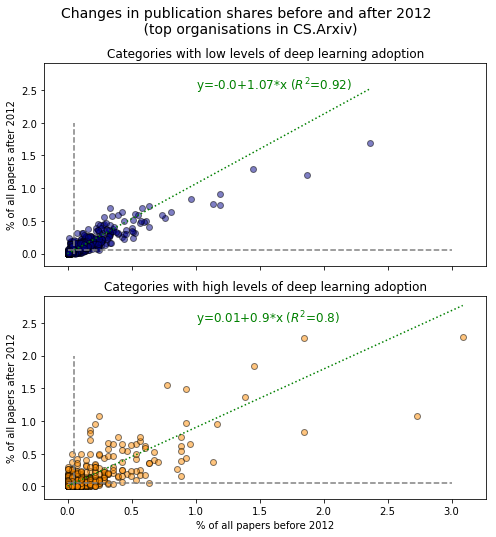

In [34]:
plot_shares_comparison(changes_2012,
                      title='Changes in publication shares before and after 2012 \n (top organisations in CS.Arxiv)')

plt.savefig(fig_path+'/{date}_publication_share_changes.pdf'.format(date=today_str),bbox_inches='tight')

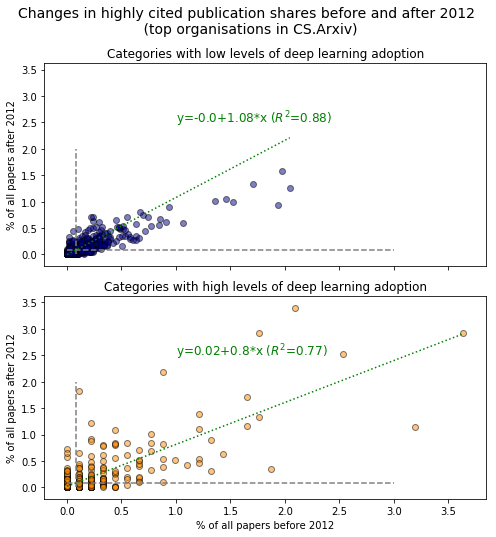

In [35]:
plot_shares_comparison(changes_2012_high_cit,pc_to_consider=0.9,
                      title='Changes in highly cited publication shares before and after 2012 \n (top organisations in CS.Arxiv)')

plt.savefig(fig_path+'/{date}_publication_share_changes_high_citations.pdf'.format(date=today_str),bbox_inches='tight')

#### Transitions in positions

In [36]:
#NB a couple of things I need to change in the geo class and other code: all count variables with
#same columns.


In [37]:
#Read some metadata [should probably take all this stuff above]
country_continent = pd.read_csv(ext_data+'/country_continent.csv.csv',keep_default_na=False,)

country_continent_code = {x:y for x,y in zip(country_continent.iloc[:,0],
                                            country_continent.iloc[:,1])}


#Match orgs to countries and continents

institutes = papers_flat.drop_duplicates('organisation')[['organisation','iso_code','country','lat_lons']].reset_index(drop=True)
institutes['continent'] = [country_continent_code[x] if x in country_continent_code.keys() else np.nan for x in institutes['iso_code']]

institute_geo_data = {x:{'country':c,'continent':cont,
                         'lat_lon':lat_lon} for x,c,cont,lat_lon in zip(institutes['organisation'],
                                                                           institutes['country'],
                                                                           institutes['continent'],
                                                                      institutes['lat_lons'])}

all_continents =set(institutes.continent)

In [44]:
#I will continue developing this later.

class DlRankingAnalysis():
    '''
    This class analyses changes in the rankings of organisations, countries and cities in the DL data.
    
    It contains methods to:
    -Generate ranking variables
    -Bin ranking variables in categories
    -Generate contingency tables based on those categories
    -Plot the contingency tables
    
    '''
    
    def __init__(self,geo_object,institute_geo_data):
        '''
        the DlRankingAnalysis class is initialised takes a dlPaperGeoAnalysis object and the
        lookup with institute addresses etc
        
        
        '''
        
        self.geo_data = geo_object
        self.institute_geo_data = institute_geo_data
        
        #We will store some stuff here
        self.location_outputs = {}
        
    def get_ranking_variable(self,variable,unit_analysis,pc=0.9):
        '''
        Variable is the variable we use for ranking:
            0 = counts
            1 = shares
            2 = lqs
        
        The unit of analysis indicates if we want to focus on countries, cities or organisations
        
        
        pc is the percentile to focus on
        '''
        
        #We need to create the right variables to extract
        if unit_analysis == 'organisation':
            unit = 'org'
            
        elif unit_analysis=='city':
            unit='city'
        else:
            unit='country'
            
        #Extract the variable
        geo_data = self.geo_data
        
        #Extract the ranking variable
        ranking = geo_data.__getattribute__(unit+'_stats')[variable]
        
        #Selecting variable (we always do this on counts)
        selecting = geo_data.__getattribute__(unit+'_stats')[0].groupby(unit_analysis).sum().sum(
            axis=1).sort_values(ascending=False)
        
        #Select larger units with the pc parameter
        larger_units = selecting[selecting>selecting.quantile(pc)].index
        
        #Subset the ranking variable
        ranking_selected = ranking.set_index(unit_analysis).loc[larger_units]
        
        self.ranking_df = ranking_selected
        
        return(self)
        
    def quantize_ranking(self,qs=[0,1.1,0.25],variable='high_share'):
        '''
        This quantizes the ranking variable. We give it the quantile to use and 
        the variable we want to focus on
        
        '''
        #Load ranking df
        ranking_df = self.ranking_df
        
        #Get the index name
        unit = ranking_df.index.name
        
        #Quantiles
        quantiles = np.arange(qs[0],qs[1],qs[2])
        
        #Pivot it
        relevant_df = pd.pivot_table(ranking_df.reset_index(drop=False),index=unit,
                                 columns='period',values=variable).fillna(0)
  
        #Cut the data in both distributions
        relevant_df['quantile_first_period'] =pd.qcut(
            relevant_df['first_period'],q=quantiles,duplicates='drop',labels=False)
    
    
        relevant_df['quantile_second_period'] =pd.qcut(
            relevant_df['second_period'],q=quantiles,duplicates='drop',labels=False)
        
        self.quantized_df = relevant_df
        
        return(self)
    
    def get_contingency_table(self,location_type,location_list,get_stats=False):
        '''
        Extracts the contingency table focusing on a location type and location
        
        '''
        
        #Load the quantized df and institute geo data
        quantized_df = self.quantized_df
        institute_geo_data = self.institute_geo_data
        
        
        #Subset if we are interested in particular groups
        quantized_subset = quantized_df.loc[
            [institute_geo_data[x][location_type] in location_list for x in quantized_df.index],:]
    
        #Extract contingency table
        cont = pd.crosstab(
            quantized_subset['quantile_first_period'],quantized_subset['quantile_second_period'],
            normalize=0)
        
        
        if get_stats==True:
            table_as_matrix = np.array(cont)
        
            #Extract the diagonal
            diag = np.mean(np.diag(table_as_matrix))

            #Upper triangle
            upper_triangle = np.mean(np.triu(table_as_matrix))

            #Lower triangle
            lower_triangle = np.mean(np.tril(table_as_matrix))
            
            return([cont,[diag,upper_triangle,lower_triangle]])

        else:
            return(cont)
        

In [39]:
def make_heatmat(cont_table,ax):
    '''
    This function takes a contingency table and creates a heatmap representing changes in activity
    between two periods
    '''
    
    nice_names = ['Quartile '+ str(x+1) for x in np.arange(0,4)]
    
    ax.imshow(cont_table,aspect='auto',cmap='bwr',
             vmin=0,vmax=1
             )
    
    
    ax.set_xticks(cont_table.columns)
    ax.set_xticklabels([nice_names[x] for x in cont_table.columns],rotation=45,ha='right',size=12)
    
    
    ax.set_yticks(cont_table.index)
    ax.set_yticklabels([nice_names[x] for x in cont_table.index],size=12)
    ax.set_ylabel('First period',size=14)
    ax.set_xlabel('Second period',size=14)
    
    for (j,i),label in np.ndenumerate(cont_table):
        ax.text(i,j,str(int(100*label))+'%',ha='center',va='center')
        #ax.text(i,j,label,ha='center',va='center')

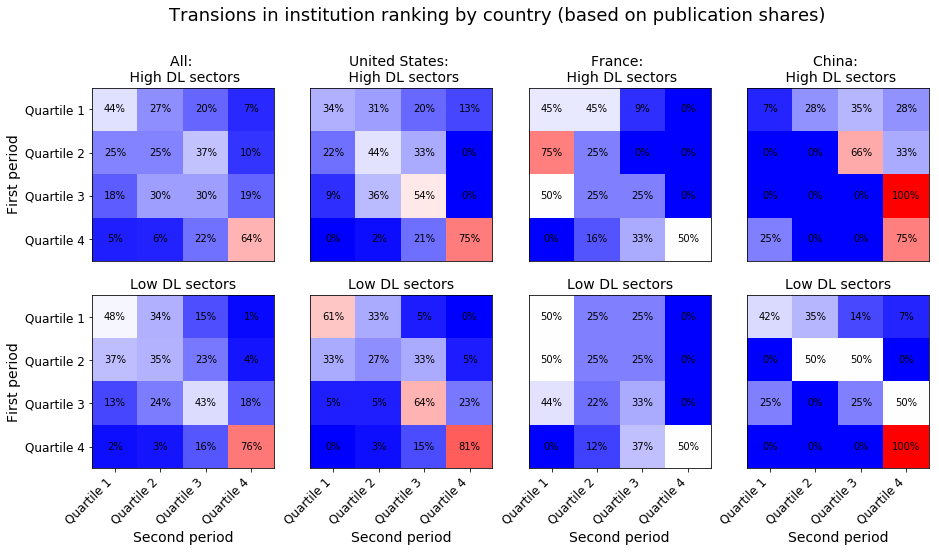

In [42]:
#Initialise the class to work with

#Reinitialise
ranking_analysis = DlRankingAnalysis(changes_2012,institute_geo_data).get_ranking_variable(
    1,'organisation').quantize_ranking()

fig,ax = plt.subplots(ncols=4,nrows=2,
                      #sharex=True,sharey='col',
                      figsize=(15,7),gridspec_kw={'height_ratios':[3,3]})

for num,x in enumerate([['continent',all_continents],['country',['United States']],
                  ['country',['France']],['country',['China']]]):
    
    #Need to initialise the class to get the high and low values
    ctable = [ranking_analysis.quantize_ranking(variable=v).get_contingency_table(location_type=x[0],
        location_list=x[1],get_stats=False) for v in ['high_share','low_share']]
    
    
    make_heatmat(ctable[0],ax[0][num])
    make_heatmat(ctable[1],ax[1][num])
    
    
    ax[0][num].get_xaxis().set_visible(False)
    
    country = 'All' if num==0 else x[1][0]
    
    ax[0][num].set_title('{country}: \n High DL sectors'.format(country=country),size=14)
    ax[1][num].set_title('Low DL sectors',size=14)
    
    if num>0:
        ax[0][num].get_yaxis().set_visible(False)
        ax[1][num].get_yaxis().set_visible(False)
        ax[1][num].set_ylabel('')

plt.subplots_adjust(hspace=0.2,wspace=0.2)

fig.suptitle('Transions in institution ranking by country (based on publication shares)',size=18,y=1.04)


plt.savefig(fig_path+'/{today}_transition_matrices.pdf'.format(today=today_str),bbox_inches='tight')   

In [45]:
#Reinitialise
ranking_analysis = DlRankingAnalysis(changes_2012,institute_geo_data).get_ranking_variable(
    1,'organisation').quantize_ranking()

china_stats = ranking_analysis.get_contingency_table(location_type='country',location_list=['China'],
                                                  get_stats=True)[1]

france_stats = ranking_analysis.get_contingency_table(location_type='country',location_list=['France'],
                                                  get_stats=True)[1]

In [46]:
china_stats

[0.20535714285714285, 0.234375, 0.066964285714285712]

In [47]:
france_stats

[0.36363636363636365, 0.125, 0.21590909090909088]

#### What explains changes in rankings?

In [48]:
from scipy.stats import ttest_ind

In [51]:
#Produce 2 boxplots comparing share of DL papers in organisations tha went up/down.

#Get the quantised info
quantized_df = ranking_analysis.quantized_df.copy()

In [52]:
#We creeate variables that capture change
quantized_df['change'] = ['up' if y>x else 'stable' if x==y else 'down' 
                               for x,y in zip(quantized_df['quantile_first_period'],
                                             quantized_df['quantile_second_period'])]

quantized_df['change_extreme'] = ['up' if y>x+2 else 'down' if x>y+2 else 'stable' 
                               for x,y in zip(quantized_df['quantile_first_period'],
                                             quantized_df['quantile_second_period'])]

org_paper_share = pd.crosstab(papers_flat.loc[papers_flat.year>=2012,'organisation'],
                              papers_flat.loc[papers_flat.year>=2012,'is_dl_cex1'],normalize=0)

org_paper_share.columns=['not_dl_share','is_dl_share']

quant_share = pd.concat(
    [quantized_df,org_paper_share],axis=1,join='inner')


In [53]:
def shares_boxplot(df,variable,title,ax=ax):
    '''
    This function creates a box plot comparing shares of activity in organisations that experienced
    different changes in ranking between before and after 2012.
    '''
    
    #This creates a list with 3 elements (the three distributions we want to plot)
    data = [100*df.loc[df[variable]==x,'is_dl_share'] for x in ['down','stable','up']]
    ax.boxplot(data)
    ax.set_title(title,size=14)
            
            
            

/usr/local/lib/python3.5/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


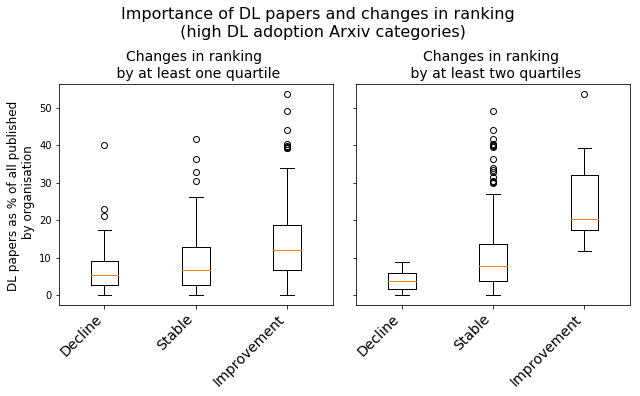

In [54]:
fig,ax = plt.subplots(figsize=(9,5),ncols=2,sharey=True)

shares_boxplot(quant_share,'change',ax=ax[0],title='Changes in ranking \n by at least one quartile')
shares_boxplot(quant_share,'change_extreme',ax=ax[1],title='Changes in ranking \n by at least two quartiles')



ax[0].set_xticklabels(['Decline','Stable','Improvement'],
                      rotation=45,ha='right',
                      size=14)
ax[1].set_xticklabels(['Decline','Stable','Improvement'],
                      rotation=45,ha='right',
                      size=14)

ax[0].set_ylabel('DL papers as % of all published \n by organisation',size=12)

fig.suptitle('Importance of DL papers and changes in ranking \n (high DL adoption Arxiv categories)',y=1.09,size=16)

plt.tight_layout()

plt.savefig(fig_path+'/{date}_ranking_change_dl.pdf'.format(date=today_str),bbox_inches='tight')

In [55]:
ttest_ind(quant_share.loc[quant_share.change_extreme=='up','is_dl_share'],
     quant_share.loc[quant_share.change_extreme=='down','is_dl_share'])

Ttest_indResult(statistic=4.2020234916110635, pvalue=0.00053580481097689466)

#### And finally a map / network

In [56]:
import geopandas as gp
import networkx
import itertools

#Here is where we got the shapefiles:
#http://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-0-countries/


world_shape = gp.read_file(ext_data+'/country_shapes/ne_10m_admin_0_countries.shp')

In [57]:
#Functions
def extract_network_from_corpus(label_corpus, edge_attr="None", stop_words=None):
    """
    Extracts a network object from a list or series where every observation is a list of co-ocurring observations
    (e.g. interacting agents, or co-occurring words). 
    In the network output, the labels are nodes and co-occurrences between them are edges. 
    Weight is number of co-occurrences. There is the option to consider additional edge attributes.

    Inputs:
    label_corpus: corpus of documents with label co-occurrence or node interaction.
    edge_attr: an edge attribute associated to the interaction. It defaults to the string none (which we use
        for control flow)
    stop_words: labels to remove (e.g. generic terms)
    
    Returns a networkx object.
    
    """
    label_pairs_container =[]
    
    #!!! TODO Using type to control flow feels a bit hacky.
    if type(edge_attr) != str:
        #Container for pairs of labels
        edge_attr_name = edge_attr.name
    
    #For each pair
    for i in range(len(label_corpus)):
        #List of tuples where every tuple is a combination of topics
        pairs = list(combinations(label_corpus.iloc[i], 2))

        #Extract these as lists of dicts capturing connections between topics, and add those to the container.
        #NB we are sorting the tuples to make sure that we don't duplicate edges.
        if len(pairs)>0:
            cont = [{'e1':sorted(tup)[0],'e2':sorted(tup)[1]} for tup in pairs]

            #Give each edge its corresponding attribute (if we have one)
            if type(edge_attr) != str:
                for d in cont:
                    d.update({edge_attr_name: edge_attr[i]})

            label_pairs_container.append(cont)

    #Flatten dict list and turn into DF
    label_pairs_df = pd.DataFrame([ds for sublist in label_pairs_container for ds in sublist])
    
    #Extract weights (depends on edge_attr)
    if type(edge_attr) != str:
        label_edgelist = pd.DataFrame(label_pairs_df.groupby(['e1','e2',edge_attr_name]
                                                        ).size()).reset_index().sort_values(by=0,ascending=False)
    else:
        label_edgelist = pd.DataFrame(label_pairs_df.groupby(['e1','e2']
                                                        ).size()).reset_index().sort_values(by=0,ascending=False)
    
    label_edgelist.rename(columns={0:'weight'},inplace=True)
    
    #Remove stop-words
    if stop_words != None:
        has_ttm =  [x in stop_words or y in stop_words for x,y in zip(label_edgelist['e1'],label_edgelist['e2'])]
        label_edgelist = label_edgelist[-pd.Series(has_ttm)]
    
    #Create label graph
    if type(edge_attr) != str:
        label_graph = nx.from_pandas_dataframe(label_edgelist,'e1','e2',['weight',edge_attr_name])
    else:
        label_graph = nx.from_pandas_dataframe(label_edgelist,'e1','e2',['weight'])
    
    return(label_graph)

def plot_world_map(ax):
    '''
    This function plots a map of the world

    
    
    '''
    #Plot map
    world_shape.plot(ax=ax,edgecolor='black',color='lightgrey',linewidth=0.2)

    #Prettify
    #Remove areas with no activity (Anctartica etc)
    ax.set_ylim((-70,85))
    ax.set_xlim((-175,185))

    #Remove coordinates
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [58]:
class DlNetworkAnalysis():
    '''
    This class converts the DL data into a network ready for processing
    
    The main method, make_network, will create the network object for a set
    # of papers (eg in different adoption groups) and add node attributes
    The method subset_network will create a subset network based on a list of organisations and weight threshold
    The function
    
    '''
    
    def __init__(self,geo_object):
        '''
        Takes a geo object
        
        '''
        
        self.papers = geo_object.papers_flat
        
    def make_network(self,variable='all'):
        '''
        Makes a network.
        Variable is either 'all' or a tuple where the first value is the variable and the value is a list with
        the subset we want
        
        '''
        
        papers = self.papers
        
        #Focus only on papers with organisation data
        papers_with_org = papers.loc[[x!=None for x in papers.organisations],:]
        
        #Store (we can check for biases later)
        self.papers_with_org = papers_with_org
        
        #This depends on the subset
        if variable!='all':
            papers_selected = papers_with_org.copy()
            
            #Loops over the list of variables and reduces the network
            for var in variable:
                papers_selected = papers_selected.loc[[x == var[1] for x in papers_selected[var[0]]],:]
        else:
            papers_selected = papers_with_org
        
        #Extract network
        network = extract_network_from_corpus(papers_selected.organisations)
        
        #Enrich network with geo data
        
        network = geocode_network(network)        
        
        #And that's the network
        self.network = network
        
        return(self)
        
    def subset_network(self,org_focus,pc=0.9):
        '''
        This method subsets the network to focus on a list of 
        specific organisations (for example those which
        gained rankings, as identified previously) or weigths above a certain threshold
        
        '''
        
        #Load the network
        network = self.network
        
        #Get a shared threshold
        weight_threshold = pd.Series([e[2]['weight'] for e in network.edges(data=True)]).quantile(pc) 
        #weight_threshold=70
        
        
        #Get the network for the selected organisations
        network_selected = nx.Graph([e for e in network.edges(data=True) if any(x in org_focus for x in [e[0],e[1]])])
        
        #Get the weight threshold and subset
        #weight_threshold = pd.Series([e[2]['weight'] for e in network_selected.edges(data=True)]).quantile(pc) 

  
        #Subset again
        network_selected_2 = nx.Graph([e for e in network_selected.edges(data=True) if e[2]['weight']>weight_threshold])
        
        #Geocode
        network_selected_2 = geocode_network(network_selected_2)
        
        #Save
        self.network_selected = network_selected_2
        
        return(self)
        
    

In [59]:
def geocode_network(network): 
    '''
    This function geocodes a network
    
    '''
    for node in network.node:
        network.node[node]['lat'] = institute_geo_data[
            node]['lat_lon'][0] if institute_geo_data[node]['lat_lon'][0]!=np.nan else np.nan
        network.node[node]['lon'] = institute_geo_data[
            node]['lat_lon'][1] if institute_geo_data[node]['lat_lon'][1]!=np.nan else np.nan
        network.node[node]['continent'] =institute_geo_data[
            node]['continent'] if institute_geo_data[node]['continent']!=np.nan else np.nan
        network.node[node]['country'] =institute_geo_data[
            node]['country'] if institute_geo_data[node]['country']!=np.nan else np.nan
    return(network)
            


In [60]:
#What do we want to draw here?
#A network with total papers and networks between organisations that climbed in the rankings and
#organisations that declined in the rankings?

In [61]:
#Organisations: total of activity

org_act = pd.crosstab(papers_flat['organisation'],
                      papers_flat['is_dl_cex1'])

#Organisations that won and lost importance
gained_imp = quantized_df.loc[quantized_df.change=='up',:].index
lost_imp = quantized_df.loc[quantized_df.change=='down',:].index

#Extract the networks
gained_net  = DlNetworkAnalysis(changes_2012).make_network(
    [['adoption_group','high']]).subset_network(gained_imp,pc=0.975).network_selected
lost_net  = DlNetworkAnalysis(changes_2012).make_network(
    [['adoption_group','high']]).subset_network(lost_imp,pc=0.975).network_selected


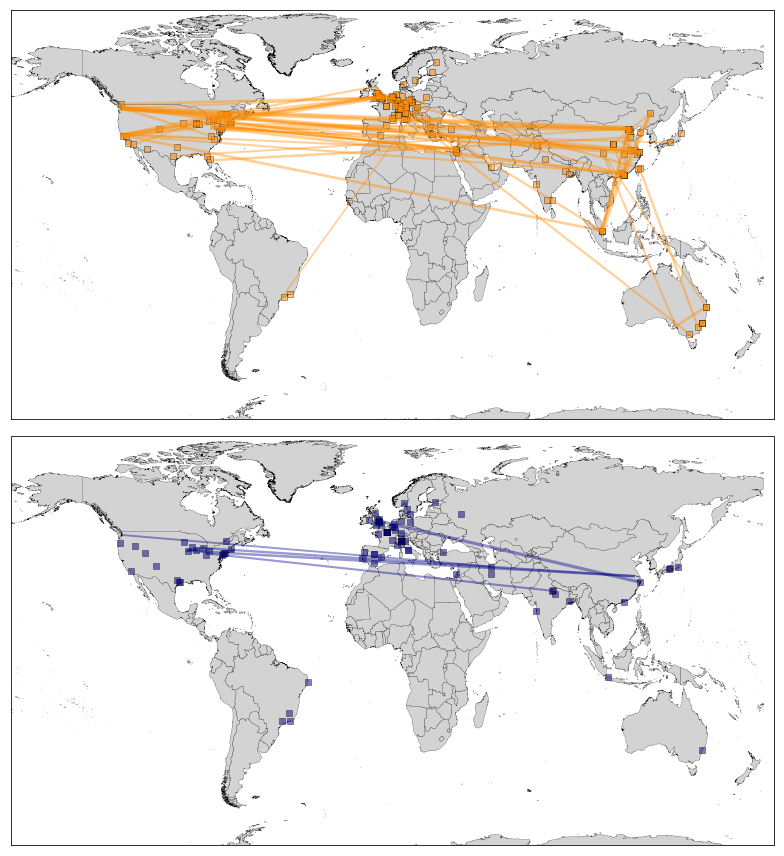

In [64]:
#Plot locations that gained and lots importance?

#Draw map
fig,ax = plt.subplots(figsize=(11,12),
                      nrows=2
                     )
plot_world_map(ax[0])
plot_world_map(ax[1])

#Consider changes
for org in gained_imp:
    org_geo = institute_geo_data[org]
    
    try:
        ax[0].scatter(org_geo['lat_lon'][1],org_geo['lat_lon'][0],
                   s=30,
               #s=org_act_dict[org][0]*10,
                   marker='s',color='darkorange',alpha=0.5,edgecolor='black',linewidth=0.7)
    #ax.scatter(gain_geo[org][1],gain_geo[org][0],s=gain_act[org][0]*10,marker='s',color='blue',alpha=0.75)
        #ax.text(gain_geo[org][1],gain_geo[org][0],s=org,size=9)
        
    except:
        pass
    
for edge in gained_net.edges(data=True):
    n1_lat = gained_net.node[edge[0]]['lat']
    n1_lon = gained_net.node[edge[0]]['lon']
    
    
    n2_lat = gained_net.node[edge[1]]['lat']
    n2_lon = gained_net.node[edge[1]]['lon']


    ax[0].plot([n1_lon,n2_lon],[n1_lat,n2_lat],linewidth=edge[2]['weight']/15,color='darkorange',alpha=0.4)

for org in lost_imp:
    org_geo = institute_geo_data[org]
    try:
        ax[1].scatter(org_geo['lat_lon'][1],org_geo['lat_lon'][0],
               #s=org_act_dict[org][0]*10,
            s=30,
            marker='s',color='darkblue',alpha=0.5,edgecolor='black',linewidth=0.7)
    except:
        pass
    
    
for edge in lost_net.edges(data=True):
    n1_lat = lost_net.node[edge[0]]['lat']
    n1_lon = lost_net.node[edge[0]]['lon']
    
    
    n2_lat = lost_net.node[edge[1]]['lat']
    n2_lon = lost_net.node[edge[1]]['lon']


    ax[1].plot([n1_lon,n2_lon],[n1_lat,n2_lat],linewidth=edge[2]['weight']/15,color='darkblue',alpha=0.4)
    
plt.tight_layout()



#### Other ideas

* Detect communities and look at the distances between them. 
  * What's the composition of the communities? Do they tend to be formed by new entrants or combinations?
  * Are the communities formed inside or between countries?
  * How does this compare with the situation in other fields?
 
* Measure average distances between co


